# Error propagation contour plots

#### Load needed packages

In [1]:
#remove tropics
#calculate pH-ALK pair only for output variable CO3 only

In [2]:
import rpy2

# necessary to workaround the error: /u01/anaconda2/lib/libreadline.so.6: undefined symbol: PC
# https://www.rittmanmead.com/blog/2016/07/using-r-jupyter-notebooks-big-data-discovery/
import readline

%load_ext rpy2.ipython

In [3]:
%%R
#libraries previously installed using:
library(seacarb)
library(oce)
library(gsw)

#library(Hmisc)   #for minor ticks in plot

packageVersion('seacarb')

/homel/cnangini/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Le chargement a nécessité le package : oce

  warnings.warn(x, RRuntimeWarning)
/homel/cnangini/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Le chargement a nécessité le package : gsw

  warnings.warn(x, RRuntimeWarning)


[1] ‘3.1.1’


## 1. Get routines and specify input vars

### 1.1 Read in needed subroutines

In [4]:
%%R
#branch buffesm1 of seacarb-git
source("/homel/cnangini/PROJECTS/seacarb-git/R/errhalf.R")
source("/homel/cnangini/PROJECTS/seacarb-git/R/errmid.R")
source("/homel/cnangini/PROJECTS/seacarb-git/R/errors.R")
source("/homel/cnangini/PROJECTS/seacarb-git/R/derivnum.R")

# source("/homel/orr/Software/R/seacarb-git-orr/R/updateall.R")

### 1.2 Specifiy input variables & errors (non-flag dependant), i.e., except for the input pair

### 1.3 Specify input pair of variables and corresponding input errors

In [5]:
%%R
# Mean surface-ocean conditions
temp  = 18
salt  = 33.96  #35 
press = 0

Phos = 2.e-6; Sil = 60.e-6
# Phos = 0.0; Sil =0.0

# Other errors - not flag dependant
salt_e = 0.01    #(psu)
temp_e = 0.01   #(C)

Pt_e = 0.1e-6
Sit_e = 4.0e-6

In [6]:
%%R
# Specify flag & corresponding 2 input variables 
flag = 15

# Approximate regional values (picked off of Fig. 3.2 from Orr, 2011)
ALK_socn = 2295e-6
DIC_socn = 2155e-6
temp_socn  = -0.49
salt_socn  = 33.96 

ALK_trop = 2300e-6
DIC_trop = 1960e-6
temp_trop  = 27.01
salt_trop  = 34.92

# Specify errors
  ALK_e <- seq(0., 20., 1.0) * 1e-6
# ALK_e = seq(0., 20., 10.0) * 1e-6
# Economize (for method='mc'): 9 error estimates (in umol/kg)
# ALK_e = c(0, 0.5, 1, 2, 4, 8, 12, 16, 20) * 1e-6
  DIC_e <- ALK_e

  var1_e <- ALK_e
  var2_e <- DIC_e

  pCO2_e <- seq(0,20,1)
  pH_e   <- seq(0,0.03,0.0015)

### 1.4 Compute derived carbonate system vars with std seacarb routine `carb`:

In [7]:
%%R
# Compute derived carbonate system variables with standard seacarb routine 'carb':

#At-Ct pair
#----------

# Southern Ocean
vars_socn <- carb  (flag=15, var1=ALK_socn, DIC_socn, S=salt_socn, T=temp_socn, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                    k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')
# Tropics
vars_trop <- carb  (flag=15, var1=ALK_trop, DIC_trop, S=salt_trop, T=temp_trop, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                    k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')

pH_socn <- vars_socn$pH
pH_trop <- vars_trop$pH

# Compute H+ based on pH definition (ph = -log10[H+], where [H+] is the hydrogen ion concentration in mol/kg
H = 10^(-1*vars_socn$pH)

# Keep only key columns to be consistent with output from 'errors.R' routine (called below)
vars_socn <- data.frame(H, vars_socn[,c('pH','CO2','fCO2','pCO2','HCO3','CO3','OmegaAragonite','OmegaCalcite')] )
vars_socn
# Duplicate rows in *vars* until same as number of members of error vector ALK_e
#numerrs <- length(dat$Var1)
numerrs <- length(ALK_e)
vars_socn <- vars_socn[rep(row.names(vars_socn), numerrs), ]
#nrow(vars_socn)

#Do the same for the tropics
H = 10^(-1*vars_trop$pH)
vars_trop <- data.frame(H, vars_trop[,c('pH', 'CO2','fCO2','pCO2', 'HCO3','CO3','OmegaAragonite','OmegaCalcite')] )
vars_trop
vars_trop <- vars_trop[rep(row.names(vars_trop), numerrs), ]
#nrow(vars_trop)


In [8]:
%%R
# vars_socn
pH_socn

[1] 8.111823


### 1.5 Use error vectors to build 2x2 error arrays, one for each input pair 

#### Make error arrays (2x2)

In [9]:
%%R
  dat <- expand.grid(DIC_e, ALK_e)

  dat_pHAt   <- expand.grid(pH_e,  ALK_e)
  dat_pHCt   <- expand.grid(pH_e,  DIC_e)
  dat_AtCt   <- expand.grid(DIC_e, ALK_e)
  dat_pCO2pH <- expand.grid(pCO2_e,  pH_e)
  dat_pCO2At <- expand.grid(pCO2_e,  ALK_e)
  dat_pCO2Ct <- expand.grid(pCO2_e,  DIC_e)

# For later use of input pH error combined with other computed errors for At, Ct, pCO2
# Use identity: -log(10) dpH = dH/H 
  H_e <- abs(-log(10) * pH_e * vars_socn$H[1])

  dat_pHpH   <- expand.grid(pH_e,  pH_e)
  dat_HH   <- expand.grid(H_e,  H_e)

In [10]:
%%R
dat

       Var1    Var2
1   0.0e+00 0.0e+00
2   1.0e-06 0.0e+00
3   2.0e-06 0.0e+00
4   3.0e-06 0.0e+00
5   4.0e-06 0.0e+00
6   5.0e-06 0.0e+00
7   6.0e-06 0.0e+00
8   7.0e-06 0.0e+00
9   8.0e-06 0.0e+00
10  9.0e-06 0.0e+00
11  1.0e-05 0.0e+00
12  1.1e-05 0.0e+00
13  1.2e-05 0.0e+00
14  1.3e-05 0.0e+00
15  1.4e-05 0.0e+00
16  1.5e-05 0.0e+00
17  1.6e-05 0.0e+00
18  1.7e-05 0.0e+00
19  1.8e-05 0.0e+00
20  1.9e-05 0.0e+00
21  2.0e-05 0.0e+00
22  0.0e+00 1.0e-06
23  1.0e-06 1.0e-06
24  2.0e-06 1.0e-06
25  3.0e-06 1.0e-06
26  4.0e-06 1.0e-06
27  5.0e-06 1.0e-06
28  6.0e-06 1.0e-06
29  7.0e-06 1.0e-06
30  8.0e-06 1.0e-06
31  9.0e-06 1.0e-06
32  1.0e-05 1.0e-06
33  1.1e-05 1.0e-06
34  1.2e-05 1.0e-06
35  1.3e-05 1.0e-06
36  1.4e-05 1.0e-06
37  1.5e-05 1.0e-06
38  1.6e-05 1.0e-06
39  1.7e-05 1.0e-06
40  1.8e-05 1.0e-06
41  1.9e-05 1.0e-06
42  2.0e-05 1.0e-06
43  0.0e+00 2.0e-06
44  1.0e-06 2.0e-06
45  2.0e-06 2.0e-06
46  3.0e-06 2.0e-06
47  4.0e-06 2.0e-06
48  5.0e-06 2.0e-06
49  6.0e-06 2.0e-06


### 1.6 Specify state-of-art (soa) errors for vars: see error-propagation manuscript (Orr et al. 2017, Table 1) 

These will be plotted as crosses on the error-space diagrams

In [11]:
%%R
ALK_e_soa   <- 2 #umol/kg
DIC_e_soa   <- 2 #umol/kg
pCO2_e_soa  <- 2 #umol/kg
pH_e_soa    <- c(0.003, 0.01)  #total scale

pH_e_soa2   <- pH_e_soa
ALK_e_soa2  <- c(ALK_e_soa, ALK_e_soa)
DIC_e_soa2  <- c(DIC_e_soa, DIC_e_soa)
pCO2_e_soa2 <- c(pCO2_e_soa, pCO2_e_soa)

ALK_e_soa2
DIC_e_soa2
pCO2_e_soa2
pH_e_soa2

var1_e_soa <- pH_e_soa
var1_e_soa2 <- pH_e_soa2
var2_e_soa <- ALK_e_soa
var2_e_soa2 <- ALK_e_soa2

In [12]:
%%R
ALK_e_soa2

[1] 2 2


## 2. Compute output variables in normal way (with carb)

#### 2.1 At-Ct pair

In [13]:
%%R
vars_socn <- carb  (flag=15, var1=ALK_socn, DIC_socn, S=salt_socn, T=temp_socn, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                    k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')

vars_trop <- carb  (flag=15, var1=ALK_trop, DIC_trop, S=salt_trop, T=temp_trop, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                    k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')

pH_socn <- vars_socn$pH
pH_trop <- vars_trop$pH

# Compute H+
H = 10^(-1*vars_socn$pH)

# Keep only key columns to be consistent with output from 'errors.R' routine (below)
vars_socn <- data.frame(H, vars_socn[,c('pH','CO2','fCO2','pCO2','HCO3','CO3','OmegaAragonite','OmegaCalcite')] )
vars_socn
# Duplicate rows in *vars* until same as number of members of error vector ALK_e
numerrs <- length(dat$Var1)
#numerrs
vars_socn <- vars_socn[rep(row.names(vars_socn), numerrs), ]
#nrow(vars_socn)

#Do the same for the tropics
H = 10^(-1*vars_trop$pH)
vars_trop <- data.frame(H, vars_trop[,c('pH', 'CO2','fCO2','pCO2', 'HCO3','CO3','OmegaAragonite','OmegaCalcite')] )
vars_trop
vars_trop <- vars_trop[rep(row.names(vars_trop), numerrs), ]
#nrow(vars_trop)

In [14]:
%%R
ALK_socn

[1] 0.002295


#### 2.2 pH-At pair

In [15]:
%%R

  vars_pHAt_socn <- carb  (flag=8, var1=pH_socn, ALK_socn, S=salt_socn, T=temp_socn, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                      k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')

  vars_pHAt_trop <- carb  (flag=8, var1=pH_trop, ALK_trop, S=salt_trop, T=temp_trop, Patm=1, P=press, Pt=Phos, Sit=Sil, 
                      k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='n')

  pH_pHAt_socn <- vars_pHAt_socn$pH
  pH_pHAt_trop <- vars_pHAt_trop$pH
  ALK_pHAt_socn <- vars_pHAt_socn$ALK
  ALK_pHAt_trop <- vars_pHAt_trop$ALK

# Keep only key columns to be consistent with output from 'errors.R' routine (below)
  vars_pHAt_socn <- data.frame(vars_pHAt_socn[,c('CO2','fCO2','pCO2','HCO3','CO3',
                                          'DIC', 'OmegaAragonite','OmegaCalcite')] )
  vars_pHAt_socn[1,]
# Duplicate rows in *vars* until same as number of members of error vector ALK_e
  numerrs <- length(dat_pHAt$Var1)
  vars_pHAt_socn <- vars_pHAt_socn[rep(row.names(vars_pHAt_socn), numerrs), ]
# nrow(vars_socn)

# Do the same for the tropics
  vars_pHAt_trop <- data.frame(vars_pHAt_trop[,c('CO2','fCO2','pCO2','HCO3','CO3',
                                          'DIC', 'OmegaAragonite','OmegaCalcite')] )
  vars_pHAt_trop
  vars_pHAt_trop <- vars_pHAt_trop[rep(row.names(vars_pHAt_trop), numerrs), ]

## 3. Propagate errors

### 3.1 MEASUREMENT error only, i.e., ignore errors in equilibrium constants (K's)

### 3.3 TOTAL errors (with default errors for K's)

#### 3.3.1 At-Ct pair (flag=21)

In [18]:
%%R
# Std estimates for errors in constants in errors.R routine (from Dickson & Riley, 1978; Dickson, 2010)
# epKstd  <- c(0.002, 0.01,  0.02, 0.01,  0.01, 0.02, 0.02)
# Estimates for errors in constants in errors.R routine (from Orr et al., 2017)
  #epKstd  <- c(0.004, 0.015,  0.03, 0.01,  0.01, 0.02, 0.02) #****ORIG****
  
  #FROM SINGLE NOTEBOOK
  epKstd  <- c(0.004, 0.015,  0.03, 0.01,  0.01, 0.02, 0.02, 0.01)
# Low estimates for errors in constants: only random errors for K1 & K2 (Lueker et al., 2000) and Kb (Dickson, 1990))
# epKlow  <- c(0.002, 0.005, 0.01, 0.002, 0.01, 0.02, 0.02)


#At-Ct pair
#----------

absEt_socn <- errors (flag=15, var1=ALK_socn, var2=DIC_socn, S=salt_socn, T=temp_socn, 
                      Patm=1, P=press, Pt=Phos, Sit=Sil, 
                      evar1=dat$Var2, evar2=dat$Var1, eS=0, eT=0, ePt=0, eSit=0, 
                      k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='no')
relEt_socn <- 100* absEt_socn / vars_socn

absEt_trop <- errors (flag=15, var1=ALK_trop, var2=DIC_trop, S=salt_trop, T=temp_trop, 
                      Patm=1, P=press, Pt=Phos, Sit=Sil, 
                      evar1=dat$Var2, evar2=dat$Var1, eS=0, eT=0, ePt=0, eSit=0, 
                      k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='no')
relEt_trop <- 100* absEt_trop / vars_trop

# Critical curves
# ===============
# Southern Ocean
errcirc <- errhalf(flag=15, var1=ALK_socn, var2=DIC_socn, S=salt_socn, T=temp_socn, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sig1_AtCt_socn   <- data.frame(errcirc[1]) * 1e+6
sig2_AtCt_socn   <- data.frame(errcirc[2]) * 1e+6
sigy_AtCt_socn   <- data.frame(errcirc[3]) ##HUOM! not used
sig1hp_AtCt_socn <- data.frame(errcirc[4]) * 1e+6 ##HUOM! not used
sig2hp_AtCt_socn <- data.frame(errcirc[5]) * 1e+6 ##HUOM! not used

# Tropics
errcirc <- errhalf(flag=15, var1=ALK_trop, var2=DIC_trop, S=salt_trop, T=temp_trop, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sig1_AtCt_trop   <- data.frame(errcirc[1]) * 1e+6
sig2_AtCt_trop   <- data.frame(errcirc[2]) * 1e+6
sigy_AtCt_trop   <- data.frame(errcirc[3]) 
sig1hp_AtCt_trop <- data.frame(errcirc[4]) * 1e+6  ##HUOM! not used
sig2hp_AtCt_trop <- data.frame(errcirc[5]) * 1e+6  ##HUOM! not used



#### 3.3.2 pH-At pair (flag=8)

In [19]:
%%R

#pH-At pair
absEt_pHAt_socn <- errors  (flag=8, var1=pH_socn, var2=ALK_socn, S=salt_socn, T=temp_socn, Patm=1, P=press, Pt=Phos, Sit=Sil, 
              evar1=dat_pHAt$Var1, evar2=dat_pHAt$Var2, 
              eS=0, eT=0, ePt=0, eSit=0, 
              k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="no")
relEt_pHAt_socn <- 100* absEt_pHAt_socn / vars_pHAt_socn
#absEt_pHAt_socn$pH <- NULL

absEt_pHAt_trop <- errors  (flag=8, var1=pH_trop, var2=ALK_trop, S=salt_trop, T=temp_trop, Patm=1, P=press, Pt=Phos, Sit=Sil, 
              evar1=dat_pHAt$Var1, evar2=dat_pHAt$Var2, 
              eS=0, eT=0, ePt=0, eSit=0, 
              k1k2='w14', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn='no')
relEt_pHAt_trop <- 100* absEt_pHAt_trop / vars_pHAt_trop

# Critical curves (pH-At pair)
# ===============
# Southern Ocean
errcirc <- errhalf(flag=8, var1=pH_socn, var2=ALK_socn, S=salt_socn, T=temp_socn, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sig1_pHAt_socn   <- data.frame(errcirc[1])
sig2_pHAt_socn   <- data.frame(errcirc[2]) * 1e+6
sigy_pHAt_socn   <- data.frame(errcirc[3])  ##HUOM! not used
sig1hp_pHAt_socn <- data.frame(errcirc[4])  ##HUOM! not used
sig2hp_pHAt_socn <- data.frame(errcirc[5]) * 1e+6  ##HUOM! not used


# Tropics
errcirc <- errhalf(flag=8, var1=pH_trop, var2=ALK_trop, S=salt_trop, T=temp_trop, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sig1_pHAt_trop   <- data.frame(errcirc[1])
sig2_pHAt_trop   <- data.frame(errcirc[2]) * 1e+6
sigy_pHAt_trop   <- data.frame(errcirc[3])
sig1hp_pHAt_trop <- data.frame(errcirc[4])
sig2hp_pHAt_trop <- data.frame(errcirc[5]) * 1e+6

### 3.4 Compute midline where both input members contribute equally to overall error

#### Function to strip NaNs and add a 0 at beginning of a vector

In [21]:
%%R
george <- NULL
if (is.null(george)) {aaa <-3}
print(aaa)

[1] 3


In [22]:
%%R
zenon <- function(x){
       # Get rid of NaN's
       x <- c(0.0, x[!is.na(x)]) 
       return(x)
}

#### Compute 'midline' where e1=e2

In [24]:
%%R
sigyspct <- seq(0,20,by=0.1) # in percent

# pH-At pair
# ----------
# Southern Ocean
errm <- errmid(flag=8, var1=pH_socn[1], var2=ALK_socn, S=salt_socn, T=temp_socn, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   sigyspct, epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sigm1_pHAt_socn   <- data.frame(errm[1])
sigm2_pHAt_socn   <- data.frame(errm[2]) * 1e+6

errm_socn <- errm

# Tropics
errm <- errmid(flag=8, var1=pH_trop[1], var2=ALK_trop, S=salt_trop, T=temp_trop, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   sigyspct, epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sigm1_pHAt_trop   <- data.frame(errm[1])
sigm2_pHAt_trop   <- data.frame(errm[2]) * 1e+6


# At-Ct pair
# ----------
# Southern Ocean
errm <- errmid(flag=15, var1=ALK_socn, var2=DIC_socn, S=salt_socn, T=temp_socn, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   sigyspct, epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sigm1_AtCt_socn   <- data.frame(errm[1]) * 1e+6
sigm2_AtCt_socn   <- data.frame(errm[2]) * 1e+6
# Tropics
errm <- errmid(flag=15, var1=ALK_trop, var2=DIC_trop, S=salt_socn, T=temp_socn, 
                   Patm=1, P=press, Pt=Phos, Sit=Sil,
                   sigyspct, epK=epKstd,
                   k1k2='l', kf='dg', ks="d", pHscale="T", b="u74", gas="potential", warn="n")  
sigm1_AtCt_trop   <- data.frame(errm[1]) * 1e+6
sigm2_AtCt_trop   <- data.frame(errm[2]) * 1e+6


## 4. Plot results: contours of calculated errors from input errors

### 4.1 Create file 'prettyaxes.R' to beautify subsequent plots (call it in cell below)

In [26]:
%%R
cat(' box()\n',
    'axis(1,labels=FALSE, tcl=-0.35) ; axis(1, lwd=0, line=-0.4, labels=TRUE)\n',
    'axis(2,labels=FALSE,tcl=-0.35)  ; axis(2, lwd=0, line=-0.4, las=2, labels=TRUE)\n',
    'axis(3,labels=FALSE,tcl=-0.35) ; axis(4,labels=FALSE,tcl=-0.25)\n',
   file='prettyaxes.R')

### 4.2 Define simpler labels of variables to plot

#### 4.2.1 For CO3 for At-Ct and pH-At pairs

In [27]:
%%R

#   for CO3:
#   --------

#   relative errors
    rCO3_pHAt_socn <- relEt_pHAt_socn$CO3 #za in plot for pH-At pair
    rCO3_pHAt_trop <- relEt_pHAt_trop$CO3


#   Relative changes:
    rCO3socn <- relEt_socn$CO3 #za in plot for At-Ct pair
    rCO3trop <- relEt_trop$CO3


### 4.3 Plot results

#### 4.3.1 Plot function

In [37]:
%%R
plterrcontourR <- function(sigcritXa, sigcritYa, xlab, ylab, subtitle, xlim, ylim,
                           sigcritXb, sigcritYb,
                           sighpXa, sighpYa,
                           sighpXb, sighpYb,
                           sigmidXa, sigmidYa,
                           sigmidXb, sigmidYb,
                           sigsoaX, sigsoaY,
                           x, y, za, levels1,
                                 zb, levels2,
                           methoda='flattest', methodb='edge'){
    
#   Region 'a' is Southern Ocean  ;  Region 'b' is Tropics:
    # 'contour' command must come after any 'plot', 'lines', or 'points' commands 
    plot (sigcritXa, sigcritYa, xlab=xlab, ylab=ylab, plot.title=title(main=subtitle),
          xlim=xlim, ylim=ylim, col="black", type='l', lwd=3, lty='solid',xaxt='n',yaxt='n',
          cex.lab=1.4, ann=F, xaxs='r', yaxs='r')
    lines(sigcritXb, sigcritYb, col="black", lwd=3, lty='dashed')
#   Plot critical point
    if ( is.null(sighpXa) ) {
        points(sigcritXa[11], sigcritYa[11], col="black", cex=1.7, pch=19)
        points(sigcritXb[11], sigcritYb[11], col="black", cex=1.7, pch=1)
    } else {
        points(sighpXa, sighpYa, col="black", cex=1.7, pch=19)
        points(sighpXb, sighpYb, col="black", cex=1.7, pch=1)
    }    
#   Plot mid-line (where e1 = e2 on each isoline [and between isolines])
    lines(sigmidXa, sigmidYa, col="black", lwd=1, lty='solid')
    lines(sigmidXb, sigmidYb, col="black", lwd=1, lty='dashed')
#   symbols(x=sigcritXb[11], y=sigcritYb[11], circles=1, inches=1/3, ann=F, bg="steelblue2", fg=NULL, add=TRUE)
#   Plot point(s) at state-of-the-art (soa) for absolute error in each member of the input pair
#   - pH has 2 points (random & overall error); other 3 input variables only have 1 point
    points(sigsoaX, sigsoaY, col="black", cex=1.7, pch=4)
    axis(1,labels=TRUE, tcl=-0.35, cex.axis=1.3) 
    axis(2, tcl=-0.35, labels=FALSE, las=0) 
    title(xlab = xlab, cex.lab = 1.4, line = 2.9)
    title(ylab = ylab, cex.lab = 1.4, line = 1.9)

#   Add 2 colored text strings near origin to indicate the propagated error at the origin (from constants only)
    a0 <- za[1,1]
    b0 <- zb[1,1]
    if (a0 < 1) {ndiga <- 2} else {ndiga <- 3}
    if (b0 < 1) {ndigb <- 2} else {ndigb <- 3}
    mtext( format(a0, digits=ndiga), side=1, line=2.5, at=0, srt=0,  cex=1.05, col='blue')
    mtext( format(b0, digits=ndigb), side=2, line=1.5, at=0, srt=90, cex=1.05, col='red')

#  'contour' command MUST come after any 'plot', 'lines', or 'points' commands 
#   For 'method', use 'simple, edge or flattest (flattest looks best but seems to fail often when lines are vertical)
    contour(x, y , za, levels=levels1, method=methoda, col="blue", lty=1, lwd=2, 
            yaxt='n', , labcex=1.0, add=TRUE)
    axis(2, tcl=-0.35, labels=FALSE) 

    contour(x, y, zb, levels=levels2, method=methodb, col='red',lty=2,lwd=2, labcex=1.0, add=TRUE, axes=FALSE)    
    axis(1,labels=FALSE, tcl=-0.35) ; 
    axis(2, tcl=-0.35, labels=FALSE, las=0) ; 
    axis(2, lwd=0, line=-0.4, las=2, labels=TRUE, cex.axis=1.4)
    axis(3,labels=FALSE,tcl=-0.35) ; axis(4,labels=FALSE,tcl=-0.25)
    done <- c('error contour plot')
#return(NULL)
}

#### 4.3.2 Plot Absolute errors

#### 4.3.4 Plot Relative error in CO3  for 1 input pairs (1 subplot each): pH-At, At-Ct

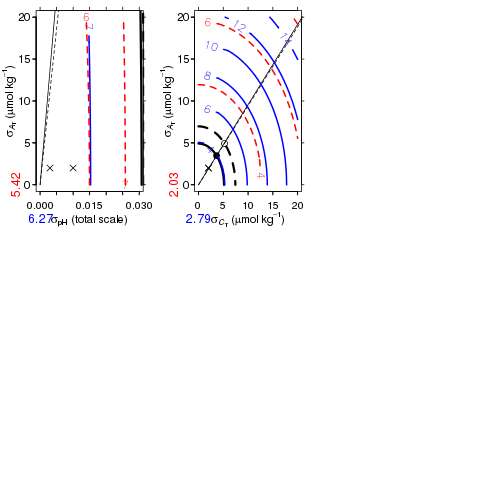

In [38]:
%%R
### Start PDF device driver to save output to figure.pdf
# Comment out line below & last line of this script to display resulting graph on computer screen
# pdf(file="halfway_CO3.pdf",  width=10.0, height=7.0)

  options(repr.plot.width=10.0, repr.plot.height=7)

#  par(mfrow=c(2,3), mar=c(6,4.7,3,2), oma=c(0,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    dim(rCO3socn) <- c(length(DIC_e), length(ALK_e))
    dim(rCO3trop) <- c(length(DIC_e), length(ALK_e))

    dim(rCO3_pHAt_socn) <- c(length(pCO2_e), length(pH_e))
    dim(rCO3_pHAt_trop) <- c(length(pCO2_e), length(pH_e))

   
#   pdf(file="Fig_AbsErrContours2_trop_socn.pdf")
#   par(mfrow=c(2,3), mar=c(3,3.4,2,1.5), oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 
    par(mfrow=c(2,3), mar=c(4,3.7,1,1.5)+0.1, oma=c(2,0,0,0.5), mgp=c(2,1,0), font.main=1) 

    subtitle <- NULL
 
#   1. pH-At
#   -------------------
#   subtitle <- expression(paste(sigma[pH]," (",mu,"mol kg"^{-1},")", sep=""))
    xlabel <- expression(paste(sigma[pH]," (total scale)",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
#   xrel <- 100./vars_pHAt_socn$CO3[1]
#   hrel <- 100. * log(10)
#   arel <- 100./vars_pHAt_socn$ALK[1]
    sigcritXa <- sig1_pHAt_socn$CO3 ;  sigcritYa <- sig2_pHAt_socn$CO3
    sigcritXb <- sig1_pHAt_trop$CO3 ;  sigcritYb <- sig2_pHAt_trop$CO3
    x <- pH_e           ;  y <- ALK_e * 1e+6
    za <- rCO3_pHAt_socn   ;  zb <- rCO3_pHAt_trop 
    xlim <- c(0,0.03) ; ylim <- c(0,20) 
    levels1 <- c(4.2, seq(4,7,by=1))   ;  levels2 <- c(3.75, seq(4,7,by=1))

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm1_pHAt_socn$CO3), zenon(sigm2_pHAt_socn$CO3),
                   zenon(sigm1_pHAt_trop$CO3), zenon(sigm2_pHAt_trop$CO3),
                   pH_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'edge', 'simple')


#   6. At-Ct
#   -------------------
    xlabel <- expression(paste(sigma[italic("C")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
    ylabel <- expression(paste(sigma[italic("A")[T]]," (",mu,"mol kg"^{-1},")",sep=""))
#   subtitle <- expression(paste(sigma[CO[3]^{"2-"}]," (",mu,"mol kg"^{-1},")", sep=""))
#   region 'a' is Southern Ocean; region 'b' is Tropics
    sigcritXa <- sig2_AtCt_socn$CO3  ;  sigcritYa <- sig1_AtCt_socn$CO3  #sig2_ is x axis; sig1_ is y axis
    sigcritXb <- sig2_AtCt_trop$CO3  ;  sigcritYb <- sig1_AtCt_trop$CO3
    x <- DIC_e*1e+6  ;  y <- ALK_e*1e+6
    za <- rCO3socn  ;  zb <- rCO3trop
    xlim <- c(0,20)  ; ylim <- xlim
    levels1 <- c(1,seq(2,20,by=2))  ;  levels2 <- levels1

    plterrcontourR (sigcritXa, sigcritYa, xlabel, ylabel, subtitle, xlim, ylim,
                   sigcritXb, sigcritYb,
                   NULL, NULL,
                   NULL, NULL,
                   zenon(sigm2_AtCt_socn$CO3), zenon(sigm1_AtCt_socn$CO3),
                   zenon(sigm2_AtCt_trop$CO3), zenon(sigm1_AtCt_trop$CO3),
                   DIC_e_soa2, ALK_e_soa2,
                   x, y, za, levels1,
                         zb, levels2,
                   'flattest', 'edge')

# Turn off device driver (to flush output to PDF)
# dev.off()

***Figure:*** Percent relative uncertainty in computed $[\text{CO}_3^{2-}]$ from six input pairs as a function of uncertainties in each member of each pair. Pairs and members are indicated by the x- and y-axis labels. Results are shown for the Southern Ocean (blue solid lines) and the tropics (red dashed lines). Sublots without pH as an input member also include the halfway curve for the Southern Ocean (black solid line) and the tropics (black dashed line). The halfway point is indicated for the Southern Ocean (filled circle) and the tropics (open circle), when it is not beyond the outer limits of the plot.